Experimenting CNN for an image classifier

The aim is to detect the variety of the flower in the image amongst the varieties available in French Polynesia.
The image database is handmade (and thus quite small...) : Google + own pictures

In order to test different architectures, the neural net definition is simplified using a list with keywords. 
The neural net is then constructed automatically using this simplified format.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

In [2]:
NbEpochsMax = 3
BatchSize = 4
NumWorkers = 4
InImgSize = 32
LearningRate = 0.003
TrainImgPath = "./imagesFlower/train/"
TestImgPath = "./imagesFlower/test/"

Computing the mean and std values for normalization based on the training images

In [3]:
imgTransf = transforms.Compose([
    transforms.Resize(InImgSize),
    transforms.CenterCrop(InImgSize),
    transforms.ToTensor()
    ])

imgSet = torchvision.datasets.ImageFolder(root=TrainImgPath, transform=imgTransf)
imgLoader = data.DataLoader( imgSet, batch_size=BatchSize, shuffle=False,  num_workers=NumWorkers)

image_means = torch.stack([sample.mean(1).mean(1) for sample, target in imgSet])
image_means = image_means.mean(0)
print( image_means )

image_std = torch.stack([sample.view(sample.size(0),-1).std(1) for sample, target in imgSet])
image_std = image_std.mean(0)
print( image_std )


tensor([0.5167, 0.5032, 0.3885])
tensor([0.2929, 0.2576, 0.2955])


Loading the images with the correct normalization and checking the available classes and number of samples

In [4]:
imgTransform = transforms.Compose([
    transforms.Resize(InImgSize),
    transforms.CenterCrop(InImgSize),
    transforms.ToTensor(),
    transforms.Normalize( mean=image_means, std=image_std )
    ])

trainset = torchvision.datasets.ImageFolder(root=TrainImgPath, transform=imgTransform)
trainloader = data.DataLoader(trainset, batch_size=BatchSize, shuffle=True,  num_workers=NumWorkers)

testset = torchvision.datasets.ImageFolder(root=TestImgPath, transform=imgTransform)
testloader  = data.DataLoader(testset, batch_size=BatchSize, shuffle=True, num_workers=NumWorkers) 

print("Nb train samples: ", len(trainset))
print("Nb test samples: ", len(testset))
print("Detected Classes : ", trainset.class_to_idx)

nbClasses = len( trainset.class_to_idx )
classes = list( trainset.class_to_idx.keys() ) #('tiare', 'tipanie')


Nb train samples:  46
Nb test samples:  10
Detected Classes :  {'tiare': 0, 'tipanie': 1}


Checking the min and max pixel values in the training images

In [5]:
max_val = -1.
min_val = 1.
for data in trainloader :
    max_t = torch.max( data[0] )
    min_t = torch.min( data[0] )
    if max_t > max_val : max_val = max_t.item()
    if min_t < min_val : min_val = min_t.item()
print( "max_val = ", max_val )
print( "min_val = ", min_val )


max_val =  2.069544553756714
min_val =  -1.9533658027648926


Experimenting with a histogram-based layer.<br>
To allow the gradient computation, it uses a gaussian based representation of the histogram bins.<br>
The approach to use gaussians to approximate a discrete object in order to use the gradient was already used in my Humanoids'08 paper (A Next-Best-View Algorithm for Autonomous 3DObject Modeling by a Humanoid Robot) but the same approach has already been used for CNN for Caffe framework in http://dde.binghamton.edu/download/model_hist/ <br>
<br>
...will need to tweak this a little more to make it really useful...

In [6]:
class GaussianHistogram( nn.Module ):
    def __init__( self, color_channel, nb_bin, min_v, max_v ):
        super( GaussianHistogram, self ).__init__()
        self.nb_bin = nb_bin
        
        # gaussian parameters
        self.neg_inv_sq_sigma = -1.0/0.02  # -1 / sigma²
        
        self.means = torch.Tensor( nb_bin )  # centers of each gaussian for each histogram bin
        interval = ( float(max_v) - float(min_v) ) / float( nb_bin )
        for i in range( nb_bin ):
            self.means[i] = float(min_v) + float(i)*interval + interval / 2.

        # each histogram bin has a parameter to influence its importance, the optimizer will look for the best weights..
        self.bin_weights = nn.Parameter( torch.rand( color_channel, nb_bin, requires_grad = True ) )
        

    def forward( self, x ):
        # x.size() -> [4,3,32,32] = batch_size, nb_channels, width, height
        # print( "Size X for hist : ", x.size() )
        nb_pixels = float( x.size(2)*x.size(3) )
        hist = torch.Tensor( x.size(0), x.size(1), self.nb_bin ).to(device)

        for b, x1 in enumerate( x ) :
            for c, x2 in enumerate( x1 ) :
                for h in range( self.nb_bin ):
                    hist[b,c,h] = ( torch.exp( ( x2.sub( self.means[h] ) ).pow(2) * self.neg_inv_sq_sigma ) ).sum()
            hist[b] *= self.bin_weights / nb_pixels
            
        # print( "hist weights : ", self.bin_weights )
        # return [batch_size, nb_channels, nb_bin]
        return hist
    

In order to prototype faster we use a basic list to define a neural net architecture (basic CNN for now).
Each element of the list represents a layer.
Layers are defined in the order in which they are executed.
Similar to nn.Sequential but slightly more compact (...but with less options now) and we don't have to compute all the numbers for input or output

One layer is composed of a name and optionally some parameters.
Currently available layers:
- "In", number_of_input_for_the_next_layer. In Must be the first layer!
- "Conv2", number_of_output, kernel_size
- "MaxPool2", kernel_size
- "AvgPool2", kernel_size
- "Drop", probability
- "ReLu"
- "View"
- "Linear", number_of_output
- "GaussHist", color_channel, number of bins, min pixel value, max pixel value
 

In [7]:
class TestNet(nn.Module):
    def __init__(self, netConfig ):
        super(TestNet, self).__init__()
        
        self.netConfig = netConfig
        imgw = InImgSize
        imgh = InImgSize
        self.func = nn.ModuleList()  # if declared as [], the parameters of the function are not stored and we get the error : optimizer got an empty parameter list
        self.viewSize = None         # we consider only one view layer in the net, for now

        currOutput = 0               # number of outputs in the last computed layer
        viewMul = 1
        
        if netConfig[0][0] != "In":
            print( "Error : the first item in the net configuration must be In")
            return
        # TODO : add more test to check consistency between layers
        
        # compute all necessary layers using the declared netConfig
        for i,l in enumerate( netConfig ):
            layerName = l[0]
            param1 = None if len(l) < 2 else l[1]
            if layerName == "In" and i==0 :
                print( "In : ", param1 )
                currOutput = param1
                self.func.append( None )    # not a Module, so it cannot be added in the List
            elif layerName == "GaussHist" and len(l)>4 :
                print( "GaussHist : ", param1, ", ", l[2], ", ", l[3], ", ", l[4] )
                self.func.append( GaussianHistogram( param1, l[2], l[3], l[4] ) )
                currOutput = l[2]
                viewMul = param1
            elif layerName == "Conv2" and len(l)>2 :
                print( "Conv2 : ", currOutput,",", param1,",", l[2] )
                # TODO : add handling of stride, dilation and padding
                self.func.append( nn.Conv2d( currOutput, param1, l[2] ) )
                currOutput = param1
                imgw = imgw - l[2] + 1
                imgh = imgh - l[2] + 1
                viewMul = imgw * imgh
            elif layerName == "AvgPool2" :
                print( "AvgPool2 : ", param1 )
                # TODO : add handling of stride, dilation and padding
                self.func.append( nn.AvgPool2d( param1, param1 ) )
                imgw = imgw / 2
                imgh = imgh / 2
                viewMul = imgw * imgh
            elif layerName == "MaxPool2" :
                print( "MaxPool2 : ", param1 )
                # TODO : add handling of stride, dilation and padding
                self.func.append( nn.MaxPool2d( param1, param1 ) )
                imgw = imgw / 2
                imgh = imgh / 2
                viewMul = imgw * imgh
            elif layerName == "Drop" :
                print( "Drop : ", param1 )
                self.func.append( nn.Dropout( p=param1 ) )
            elif layerName == "Linear" :
                print( "Linear : ", int(currOutput),",", int(param1) )
                self.func.append( nn.Linear( int(currOutput), int(param1) ) )
                currOutput = param1
            elif layerName == "ReLu" :
                print( "ReLu" )
                self.func.append( None )    # not a Module, so it cannot be added in the List
            elif layerName == "View" :
                currOutput = currOutput * viewMul
                print( "View : ", -1, ",", int(currOutput) )
                self.viewSize = currOutput
                self.func.append( None )    # not a Module, so it cannot be added in the List
            else :
                print( "Unknown layer : ", layerName )
                self.func.append( None )    # not a Module, so it cannot be added in the List

    def forward(self, x):
        for i,layer in enumerate( self.netConfig ) :
            if self.func[i] != None :
                x = self.func[i]( x )
            elif layer[0] == "View" :
                x = x.view( -1, int(self.viewSize) )
            elif layer[0] == "ReLu" :
                x = F.relu( x )
            elif layer[0] == "In" :
                None
            else :
                print("Unknown Function..")
        return x
        

In [8]:
architectures = [
    [["In",3],
    ["GaussHist",3,10,min_val,max_val],
    ["View"],
    ["Linear",60],
    ["ReLu"],
    ["Linear",30],
    ["ReLu"],
    ["Linear",len(classes)]],

    [["In",3],
    ["Conv2",10,3],
    ["ReLu"],
    ["MaxPool2",2],
    ["GaussHist",10,10,0.,1.],
    ["View"],
    ["Linear",60],
    ["ReLu"],
    ["Linear",30],
    ["ReLu"],
    ["Linear",len(classes)]],

    [["In",3],
    ["Conv2",10,3],
    ["ReLu"],
    ["MaxPool2",2],
    ["GaussHist",10,20,0.,1.],
    ["View"],
    ["Linear",60],
    ["ReLu"],
    ["Linear",30],
    ["ReLu"],
    ["Linear",len(classes)]],

    [["In",3],
    ["Conv2",10,3],
    ["ReLu"],
    ["MaxPool2",2],
    ["View"],
    ["Linear",60],
    ["ReLu"],
    ["Linear",30],
    ["ReLu"],
    ["Linear",len(classes)]],

    [["In",3],
    ["Conv2",10,3],
    ["ReLu"],
    ["MaxPool2",2],
    ["View"],
    ["Linear",80],
    ["ReLu"],
    ["Linear",60],
    ["ReLu"],
    ["Linear",len(classes)]],

    [["In",3],
    ["Conv2",10,3],
    ["ReLu"],
    ["MaxPool2",2],
    ["View"],
    ["Linear",40],
    ["ReLu"],
    ["Linear",30],
    ["ReLu"],
    ["Linear",20],
    ["ReLu"],
    ["Linear",len(classes)]],

    [["In",3],
    ["Conv2",10,3],
    ["ReLu"],
    ["MaxPool2",2],
    ["Drop",0.1],
    ["View"],
    ["Linear",50],
    ["ReLu"],
    ["Linear",40],
    ["ReLu"],
    ["Linear",len(classes)]],
    
    [["In",3],
    ["Conv2",10,5],
    ["ReLu"],
    ["MaxPool2",2],
    ["Conv2",10,3],
    ["ReLu"],
    ["MaxPool2",2],
    ["View"],
    ["Linear",80],
    ["ReLu"],
    ["Linear",60],
    ["ReLu"],
    ["Linear",len(classes)]],
]


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
best_architecture = 0
best_acc = 0.0
best_loss = 999

for archi, netConfig in enumerate(architectures):
    net = TestNet( netConfig )
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam( net.parameters(), lr=LearningRate )
    # optimizer = optim.SGD(net.parameters(), lr=LearningRate, momentum=0.9)

    best_state = copy.deepcopy( net.state_dict() )
    start_time = time.time()
    for epoch in range( NbEpochsMax ):

        # training phase 
        mean_loss = 0.
        nb_mean = 0
        for i, data in enumerate( trainloader, 0 ):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            # print( "parameters before : ", list( net.parameters() ) )

            outputs = net( inputs )
            loss = criterion( outputs, labels )
            loss.backward()
            optimizer.step()

            running_loss = loss.item()
            mean_loss += running_loss
            nb_mean += 1
            
            # print( "parameters after : ", list( net.parameters() ) )
            print('[Epoch %3d, %4d] loss: %.3f' % (epoch, i, running_loss) )

        mean_loss /= float(nb_mean)
        
        # test phase
        with torch.no_grad():
            correct = 0
            total = 0
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = net( images )
                _, predicted = torch.max( outputs.data, 1 )
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            acc = 100 * correct / total
            epoch_time = time.time() - start_time
            print('[Epoch %3d] acc: %.3f -- time: %d' % (epoch, acc, epoch_time) )

            if acc > best_acc or (acc == best_acc and mean_loss < best_loss):
                print("Backing up the network...")
                best_acc = acc
                best_loss = mean_loss
                best_state = copy.deepcopy( net.state_dict() )
                best_architecture = archi
                torch.save( net, './TahitiFlowerBest.pt' )

    computation_time = time.time() - start_time
    print('Architecture {} training finished -- {:.0f}m {:.0f}s'.format( archi, computation_time // 60, computation_time % 60) )

print("Reloading the best net : ", best_architecture )
net = torch.load( './TahitiFlowerBest.pt' )
net.to(device)


In :  3
GaussHist :  3 ,  10 ,  -1.9533658027648926 ,  2.069544553756714
View :  -1 , 30
Linear :  30 , 60
ReLu
Linear :  60 , 30
ReLu
Linear :  30 , 2
Size de X pour hist :  torch.Size([4, 3, 32, 32])
[Epoch   0,    0] loss: 0.703
Size de X pour hist :  torch.Size([4, 3, 32, 32])
[Epoch   0,    1] loss: 0.700
Size de X pour hist :  torch.Size([4, 3, 32, 32])
[Epoch   0,    2] loss: 0.647
Size de X pour hist :  torch.Size([4, 3, 32, 32])
[Epoch   0,    3] loss: 0.748
Size de X pour hist :  torch.Size([4, 3, 32, 32])
[Epoch   0,    4] loss: 0.700
Size de X pour hist :  torch.Size([4, 3, 32, 32])
[Epoch   0,    5] loss: 0.743
Size de X pour hist :  torch.Size([4, 3, 32, 32])
[Epoch   0,    6] loss: 0.654
Size de X pour hist :  torch.Size([4, 3, 32, 32])
[Epoch   0,    7] loss: 0.693
Size de X pour hist :  torch.Size([4, 3, 32, 32])
[Epoch   0,    8] loss: 0.624
Size de X pour hist :  torch.Size([4, 3, 32, 32])
[Epoch   0,    9] loss: 0.695
Size de X pour hist :  torch.Size([4, 3, 32, 32]

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type TestNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type GaussianHistogram. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Size de X pour hist :  torch.Size([4, 3, 32, 32])
[Epoch   1,    0] loss: 0.609
Size de X pour hist :  torch.Size([4, 3, 32, 32])
[Epoch   1,    1] loss: 0.741
Size de X pour hist :  torch.Size([4, 3, 32, 32])
[Epoch   1,    2] loss: 0.650
Size de X pour hist :  torch.Size([4, 3, 32, 32])
[Epoch   1,    3] loss: 0.693
Size de X pour hist :  torch.Size([4, 3, 32, 32])
[Epoch   1,    4] loss: 0.739
Size de X pour hist :  torch.Size([4, 3, 32, 32])
[Epoch   1,    5] loss: 0.733
Size de X pour hist :  torch.Size([4, 3, 32, 32])
[Epoch   1,    6] loss: 0.652
Size de X pour hist :  torch.Size([4, 3, 32, 32])
[Epoch   1,    7] loss: 0.737
Size de X pour hist :  torch.Size([4, 3, 32, 32])
[Epoch   1,    8] loss: 0.651
Size de X pour hist :  torch.Size([4, 3, 32, 32])
[Epoch   1,    9] loss: 0.697
Size de X pour hist :  torch.Size([4, 3, 32, 32])
[Epoch   1,   10] loss: 0.651
Size de X pour hist :  torch.Size([2, 3, 32, 32])
[Epoch   1,   11] loss: 0.697
Size de X pour hist :  torch.Size([4, 3,

[Epoch   1,   10] loss: 0.657
Size de X pour hist :  torch.Size([2, 10, 15, 15])
[Epoch   1,   11] loss: 0.649
Size de X pour hist :  torch.Size([4, 10, 15, 15])
Size de X pour hist :  torch.Size([4, 10, 15, 15])
Size de X pour hist :  torch.Size([2, 10, 15, 15])
[Epoch   1] acc: 50.000 -- time: 29
Backing up the network...
Size de X pour hist :  torch.Size([4, 10, 15, 15])
[Epoch   2,    0] loss: 0.611
Size de X pour hist :  torch.Size([4, 10, 15, 15])
[Epoch   2,    1] loss: 0.609
Size de X pour hist :  torch.Size([4, 10, 15, 15])
[Epoch   2,    2] loss: 0.550
Size de X pour hist :  torch.Size([4, 10, 15, 15])
[Epoch   2,    3] loss: 0.630
Size de X pour hist :  torch.Size([4, 10, 15, 15])
[Epoch   2,    4] loss: 0.600
Size de X pour hist :  torch.Size([4, 10, 15, 15])
[Epoch   2,    5] loss: 0.789
Size de X pour hist :  torch.Size([4, 10, 15, 15])
[Epoch   2,    6] loss: 0.606
Size de X pour hist :  torch.Size([4, 10, 15, 15])
[Epoch   2,    7] loss: 0.559
Size de X pour hist :  tor

[Epoch   2] acc: 100.000 -- time: 14
Architecture 7 training finished -- 0m 15s
Reloading the best net :  6


TestNet(
  (func): ModuleList(
    (0): None
    (1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (2): None
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.1, inplace=False)
    (5): None
    (6): Linear(in_features=2250, out_features=50, bias=True)
    (7): None
    (8): Linear(in_features=50, out_features=40, bias=True)
    (9): None
    (10): Linear(in_features=40, out_features=2, bias=True)
  )
)

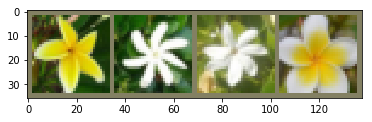

GroundTruth:  tipanie tiare tiare tipanie


In [11]:
def imshow( img ):
    # need to put color channel at the end for matplotlib
    image = img.numpy().transpose((1, 2, 0))
    
    # Un-normalize
    image = np.array(image_std) * image + np.array(image_means)
    
    plt.imshow( image )
    plt.show()

# show all images in a batch
dataiter = iter( testloader )
images, labels = dataiter.next()
imshow( torchvision.utils.make_grid(images) )

print( 'GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(BatchSize)) )

In [12]:
outputs = net( images.to(device) )
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(BatchSize)))

Predicted:  tipanie tiare tiare tipanie


In [13]:
class_correct = list(0. for i in range(nbClasses))
class_total = list(0. for i in range(nbClasses))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(nbClasses):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(nbClasses):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of tiare : 100 %
Accuracy of tipanie : 100 %


In [14]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [15]:
class FilterVisualizer():
    def __init__(self, model, size=56, upscaling_steps=12, upscaling_factor=1.2):
        self.size, self.upscaling_steps, self.upscaling_factor = size, upscaling_steps, upscaling_factor
        self.model = model
        for p in self.model.parameters(): p.requires_grad=False  # set_trainable(self.model, False)

    def visualize(self, layer, filter, lr=0.1, opt_steps=20, blur=None):
        sz = self.size
        img = np.uint8(np.random.uniform(150, 180, (sz, sz, 3)))/255  # generate random image
        activations = SaveFeatures(list(self.model.children())[layer])  # register hook

        for _ in range(self.upscaling_steps):  # scale the image up upscaling_steps times
            train_tfms, val_tfms = tfms_from_model(Net,sz) # vgg16, sz)
            img_var = V(val_tfms(img)[None], requires_grad=True)  # convert image to Variable that requires grad
            optimizer = torch.optim.Adam([img_var], lr=lr, weight_decay=1e-6)
            for n in range(opt_steps):  # optimize pixel values for opt_steps times
                optimizer.zero_grad()
                self.model(img_var)
                loss = -activations.features[0, filter].mean()
                loss.backward()
                optimizer.step()
            img = val_tfms.denorm(img_var.data.cpu().numpy()[0].transpose(1,2,0))
            self.output = img
            sz = int(self.upscaling_factor * sz)  # calculate new image size
            img = cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)  # scale image up
            if blur is not None: img = cv2.blur(img,(blur,blur))  # blur image to reduce high frequency patterns
        self.save(layer, filter)
        activations.close()
        
    def save(self, layer, filter):
        plt.imsave("layer_"+str(layer)+"_filter_"+str(filter)+".jpg", np.clip(self.output, 0, 1))

In [16]:
# FV = FilterVisualizer( net, size=56, upscaling_steps=12, upscaling_factor=1.2)
# FV.visualize( 2, 265, blur=5)

References :
- https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
- https://medium.com/datadriveninvestor/creating-a-pytorch-image-classifier-da9db139ba80
- http://dde.binghamton.edu/download/model_hist/
- ...

